In [12]:
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
using CUDA
using FixedPointNumbers
# Graphs 
using LightGraphs, SimpleWeightedGraphs
using GraphPlot, GraphRecipes
gr()

Plots.GRBackend()

## Kuramoto oscillators

## $$
\begin{aligned}
  \dot{\theta_{i}} &= \omega_{i} + \sum_{j=0}^{N} a_{ij} \sin(\theta_{j} - \theta_{i})\\
\end{aligned}
$$


## Define the graph

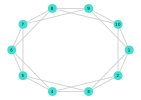

In [329]:
N = 10
G = SimpleGraph(N)

while true

    for i ∈ 1:N
        for j ∈ i:N
            if i != j && (i == j +1 || i == j-1 || i == j-2 || i == j-2) #rand(Float64) > 0.9999
                add_edge!(G, i, j)
            end
        end
    end
    
    if is_connected(G) == true
        break
    end
    
end


add_edge!(G, 1, 10)
add_edge!(G, 1, 9)
add_edge!(G, 2, 10)

gplot(G, layout=circular_layout, nodelabel=1:N)

## Adjacency matrix

In [330]:
A = adjacency_matrix(G);

## ODE

### Initial conditions

In [331]:
#Random ω
#ω = 0.5*π*randn(Float32, (N,))

#ω all equal
ω = [π for i ∈ 1:N]

#Random initial phase
#u0 = abs.(π*randn(Float32, (N,)))

#Full circle
u0 = [(2*π/(N))*i for i ∈ 1:N];

#Soliton
#u0 = [1.5 for i ∈ 1:N/2]
#u0 = append!([0. for i ∈ 1:N/2], u0);

### System

In [332]:
function Kuramoto(u, A, t)
    
    K = 3
    
    S = [sin(u[j] - u[i]) for i ∈ 1:N, j ∈ 1:N]    
    
    #ωₙ = ω +  5*Float32(1e-1)*randn(eltype(ω), size(ω))
    
    return [ω[j] + K*(1/(count(i->(i>0), Array(A[:, j]))))*(S*Array(A[:, j]))[j]   for j ∈ 1:N]
    
end


tspan = (0.0f0, 10.0f0)
prob = ODEProblem(Kuramoto, u0, tspan, A)
saveat = 0.1
solution = solve(prob, Vern7(), saveat = saveat) #abstol=1e-12, reltol=1e-12,



X = Array(solution)

# Add noise to the data
#println("Generate noisy data")
Xₙ = X #+ Float32(1e-4)*randn(eltype(X), size(X));

## Animation
### Coloring

In [333]:
function nodecolor(θ)
    #color = RGBA(mod(θ, 2*π)/(5*π), mod(θ, 2*π)/(2*π), mod(θ, 2*π)/(5*π))
    return convert(RGB{N0f8}, HSV((360/(2*π))*mod(θ, 2*π), 1, 1))
end

nodecolor (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = C:\Users\valpe\Documents\GitHub\ML_DynamicalSystems\Code\Julia\sync.gif
└ @ Plots C:\Users\valpe\.julia\packages\Plots\uCh2y\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\valpe\\Documents\\GitHub\\ML_DynamicalSystems\\Code\\Julia\\sync.gif")
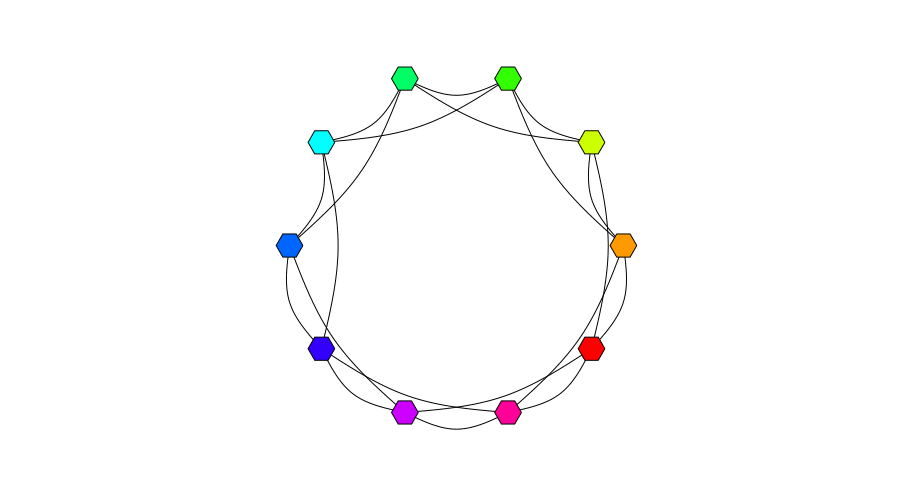

In [334]:
anim = Plots.Animation()
#graphplot(G, markersize = 0.2, nodelabel=1:N, method=:circular, markercolor =:red);
#Plots.frame(anim)
for i ∈ 1:length(Xₙ[1, :])
    graphplot(G, markersize = 0.2, nodelabel=1:N, method=:circular, markercolor = nodecolor.(Xₙ[:, i]), size = (900, 500));
    Plots.frame(anim)
end


gif(anim, "sync.gif", fps = 10)

## Plot the solution

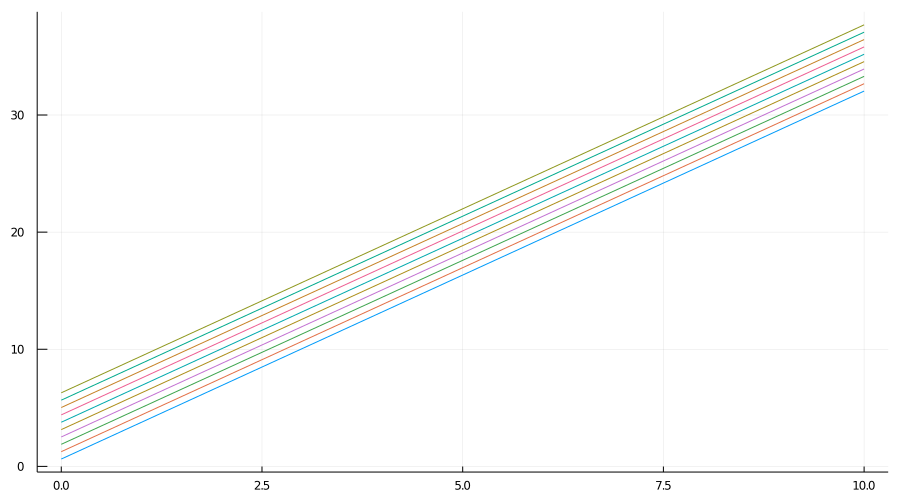

In [335]:
width = 900
height = 500

#plot(solution)
#plot(Array(solution)[1, :], Array(solution)[2, :])
#plot(Xₙ[1, :], Xₙ[2, :])

plot(solution.t, Xₙ[1, :], size = (width, height), label = false) #, label = "1", legend=:topleft,
for i ∈ 2:(N-1)
    plot!(solution.t, Xₙ[i, :], label = false) #, label = "$i"
end
plot!(solution.t, Xₙ[N, :], label = false) #, label = "$N"


## Autoencoder

In [382]:
L = Chain(Dense(N, 10, tanh), Dense(10, 5, tanh), Dense(5, 1, tanh), Dense(1, 5, tanh), Dense(5, 10, tanh), Dense(10, N))

loss(x) = sum(abs2, L(x) .- x)

ps = Flux.params(L);

data = [Xₙ[:, i] for i in 1:length(Xₙ[1, :])];

## Training with ADAM

In [383]:
#Flux.train!(loss, ps, data, ADAM(0.01))
ps = Flux.params(L)

#println(loss(Xₙ[:, 5]))

Params([Float32[-0.3308877 0.33101255 … -0.24833162 -0.48196995; 0.06534703 -0.38901716 … -0.5318941 0.375498; … ; 0.30536965 0.20273957 … 0.047014672 -0.10559193; -0.1399591 -0.13251784 … 0.18573475 0.07582796], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.3918897 -0.5513979 … 0.5482972 -0.34839424; 0.04397449 -0.29282892 … -0.5246752 0.15239717; … ; 0.16895683 0.15631391 … 0.5691034 -0.5508833; -0.2258363 -0.1210294 … -0.015363454 -0.22230391], Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.87285185 0.25370216 … 0.072347164 0.4037652], Float32[0.0], Float32[0.42646432; -0.27407146; … ; -0.69725966; 0.23358297], Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.5706944 -0.37586442 … -0.27478307 -0.16551869; 0.14352804 0.5746297 … 0.62669915 0.12971637; … ; 0.27131417 0.60680705 … -0.13446005 -0.1609178; 0.58882076 0.4834021 … -0.43747702 -0.61721], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.37311426 0.43480498 … 0.52745116 -0.49270394; -0.1250

In [408]:
Flux.train!(loss, ps, data, ADAM(0.01))
ps = Flux.params(L)

Params([Float32[-0.89523256 -0.5756391 … -0.67937165 -0.9119764; -0.3430016 -0.03173705 … -0.332395 -0.3571678; … ; 0.33991435 0.23918186 … 0.8604471 0.56102276; -0.54760444 -0.502753 … -0.34848267 -0.55447084], Float32[-0.6006689, 0.0, 0.1596941, 0.35170725, 0.0, 0.59996456, -0.6000767, -0.6005433, -0.45110905, -0.6005416  …  0.6005075, 0.60056704, -0.60050744, -0.5049172, -0.60059893, 0.6005552, -0.4519885, 0.45609468, 0.60025597, -0.57073617], Float32[0.3532946 0.8451301 … -0.9310934 0.42906788; 1.0548093 0.5377697 … -0.43747833 0.1169724; … ; -0.52155447 -0.87752503 … -0.48345074 0.43235058; 0.83657944 0.77939487 … -0.18505017 0.20810874], Float32[-0.53145397, -0.8040347, 0.4378825, 0.5656313, 0.5488165, -0.6496463, -0.6146334, -0.7637393, 0.63945067, -0.5163791  …  0.6160724, 0.33397555, -0.42148963, -0.68230456, -0.6632834, 0.6386619, 0.335187, 0.83861303, 0.6237175, -0.7396978], Float32[0.06286207 -0.29480094 … -0.5864089 -0.15651612; 0.59483296 -0.36304995 … -0.36583787 -0.4231

In [396]:
L = Chain(Dense(10, 30, tanh), Dense(30, 30, tanh), Dense(30, 10)) 
loss(x) = sum(abs2, L(x) .- [i*i for i in 1:10])
ps = Flux.params(L);


data = Iterators.repeated([i for i in 1:10], 300)
Flux.train!(loss, ps, data, ADAM(0.1))

In [325]:
L([i for i in 1:10])
loss([i for i in 1:10])

3.1119285f-10

## Training with BFGS

In [206]:
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 50)

Current loss after 110 iterations: 0.19271168
Current loss after 120 iterations: 0.10212062


 * Status: failure

 * Candidate solution
    Final objective value:     7.441945e-02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 6.31e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.25e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-03 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.72e-02 ≰ 0.0e+00
    |g(x)|                 = 2.34e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   39  (vs limit Inf)
    Iterations:    23
    f(x) calls:    50
    ∇f(x) calls:   50


## Plot the loss

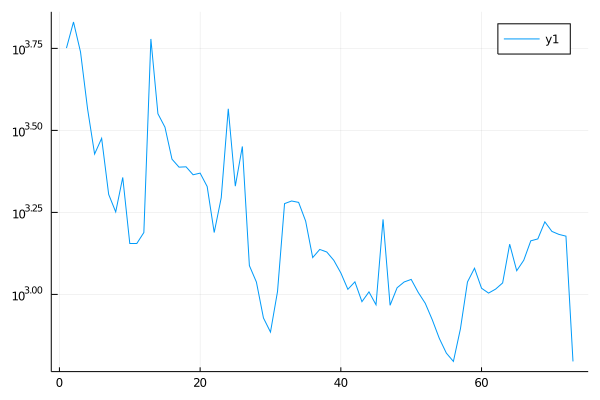

In [508]:
plot(losses, yaxis=:log)

## Plot the prediction

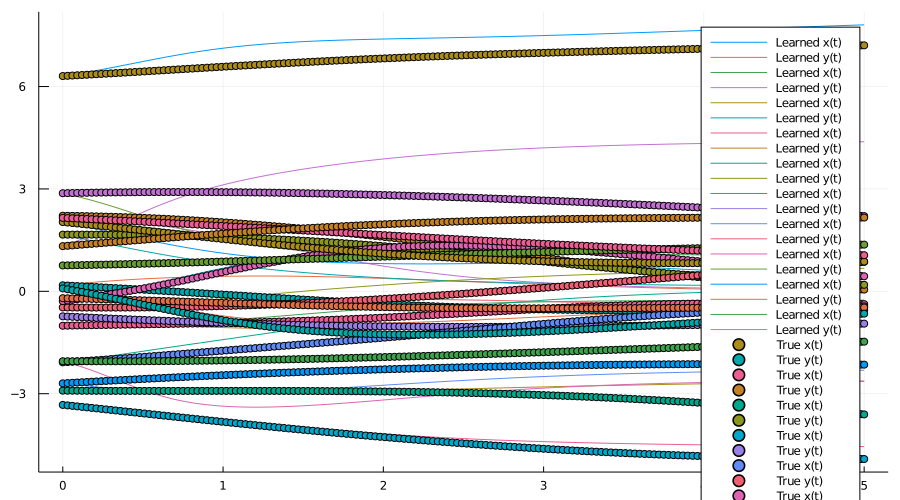

In [510]:
NNsolution = predict(res1.minimizer)
# Trained on noisy data vs real solution
plot(solution.t, NNsolution', label = ["Learned x(t)" "Learned y(t)"], size = (width, height))
scatter!(solution.t, X', label = ["True x(t)" "True y(t)"])

## Prediction

In [210]:
function dudt_2(u, p, t)
    x1, x2, x3, x4, x5, x6, x7, x8, x9 = u
    z = L(u,p)
    [z[1],
    z[2],
    z[3],
    z[4],
    z[5],
    z[6],
    z[7],
    z[8],
    z[9]]
end

# ODE problem
tspan2 = (0.0f0, 6.0f0)
prob_nn2 = ODEProblem(dudt_2, u0, tspan2, res2.minimizer)
sol_nn2 = solve(prob_nn2, Tsit5(), u0 = u0, saveat = saveat);

## Test the prediction

In [214]:
prob_test = ODEProblem(Kuramoto, u0, tspan2, p_)
solution_test = solve(prob_test, Vern7(), saveat = saveat);

## Prot together true and prediction

## Plot $q(t)$ and $p(t)$

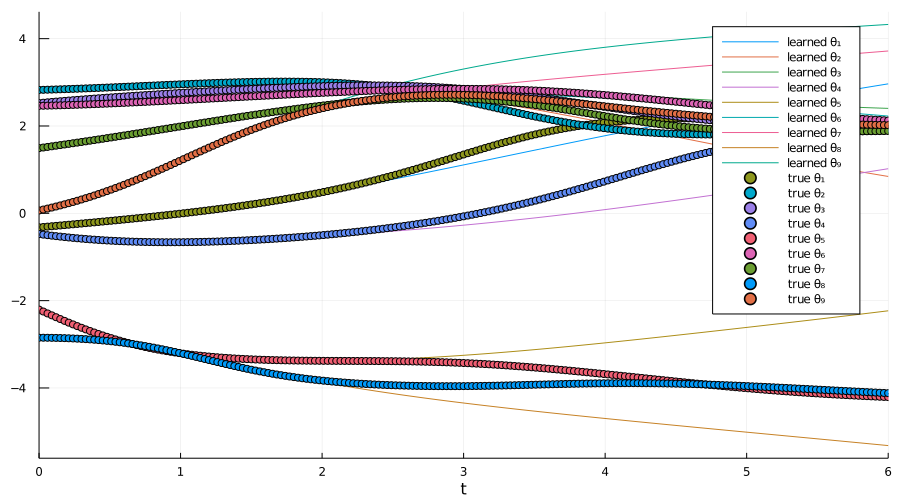

In [224]:
plot(sol_nn2, label = ["learned θ₁" "learned θ₂" "learned θ₃" "learned θ₄" "learned θ₅" "learned θ₆" "learned θ₇" "learned θ₈" "learned θ₉"], size = (width, height))
scatter!(solution_test.t, Array(solution_test)[1, :], label = "true θ₁")
scatter!(solution_test.t, Array(solution_test)[2, :], label = "true θ₂")
scatter!(solution_test.t, Array(solution_test)[3, :], label = "true θ₃")
scatter!(solution_test.t, Array(solution_test)[4, :], label = "true θ₄")
scatter!(solution_test.t, Array(solution_test)[5, :], label = "true θ₅")
scatter!(solution_test.t, Array(solution_test)[6, :], label = "true θ₆")
scatter!(solution_test.t, Array(solution_test)[7, :], label = "true θ₇")
scatter!(solution_test.t, Array(solution_test)[8, :], label = "true θ₈")
scatter!(solution_test.t, Array(solution_test)[9, :], label = "true θ₉")

--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------

# SINDy Sparse Identification of Non-linear Dynamics
### Ideal derivatives:
### we take derivatives with respect to $t$ of $(x(t), y(t))$ both from the known solution and the solution to the trained UADE

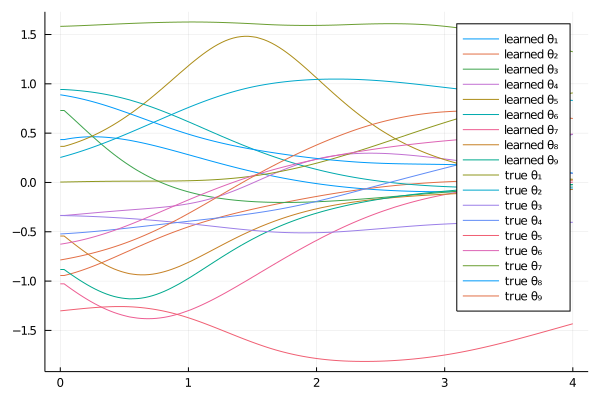

In [253]:
DX = Array(solution(solution.t, Val{1})) 

prob_nn2 = ODEProblem(dudt_2, u0, tspan, res2.minimizer)
_sol = solve(prob_nn2, Tsit5())

DX_ = Array(_sol(solution.t, Val{1}))

plot(solution.t, DX', label = ["learned θ₁" "learned θ₂" "learned θ₃" "learned θ₄" "learned θ₅" "learned θ₆" "learned θ₇" "learned θ₈" "learned θ₉"])
plot!(solution.t, DX_', label = ["true θ₁" "true θ₂" "true θ₃" "true θ₄" "true θ₅" "true θ₆" "true θ₇" "true θ₈" "true θ₉"])

## The learned derivatives

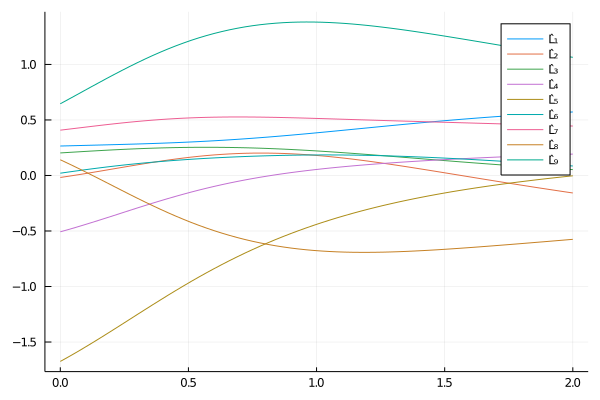

In [228]:
# Ideal data
#L̄ = [(Xₙ[2,:]/(p_[1]*p_[2]^(2)))'; -p_[1]*p_[2]*p_[3]*sin.(Xₙ[1,:]')]

# Neural network guess
L̂ = L(Xₙ, res2.minimizer)

#scatter(solution.t, L̄', label = ["L̄₁" "L̄₂" "L̄₃" "L̄₄" "L̄₅" "L̄₆" "L̄₇" "L̄₈" "L̄₉"])
plot(solution.t, L̂', label = ["L̂₁" "L̂₂" "L̂₃" "L̂₄" "L̂₅" "L̂₆" "L̂₇" "L̂₈" "L̂₉"])


#savefig("UADE.png")

# Plot the error
#scatter(abs.(L̄-L̂)', yaxis = :log)

## Create a basis for the sparse identification

In [230]:
@variables u[1:9]

# Lots of polynomials
ops = Operation[1]

for i ∈ 1:9
    for j ∈ i:9
        if i != j
            push!(ops, sin(u[i] - u[j]))
        end
    end
end

# And some other stuff
h = [ops...]
basis = Basis(h, u)

37 dimensional basis in ["u₁", "u₂", "u₃", "u₄", "u₅", "u₆", "u₇", "u₈", "u₉"]

## Optimizer for the algorithm

In [232]:
opt = SR3() 
#opt = STRRidge(0.1)


# Create the thresholds which should be used in the search process
λ = exp10.(-5:0.1:5)

# Target function to choose the results from; x = L0 of coefficients and L2-Error of the model
g(x) = x[1] < 1 ? Inf : norm(x, 2)

#Suggestion from AlCap23
#g(x) = x[1] < 1 ? Inf : norm([0.1; 10.0] .* x, 2)

g (generic function with 1 method)

## Test on original data and without further knowledge (fail)

In [254]:
println("SINDy on full ideal, unavailable data")
Ψ = SINDy(Xₙ[:, :], DX[:, :], basis, λ, opt, g = g, maxiter = 50000) # Fail
println(Ψ)
print_equations(Ψ)

SINDy on full ideal, unavailable data
Sparse Identification Result
No. of Parameters : 14
Active terms : 14
   Equation 1 : 1
   Equation 2 : 1
   Equation 3 : 1
   Equation 4 : 2
   Equation 5 : 2
   Equation 6 : 1
   Equation 7 : 4
   Equation 8 : 1
   Equation 9 : 1
Overall error (L2-Norm) : 16.231901
   Equation 1 : 0.111663446
   Equation 2 : 1.9661889
   Equation 3 : 0.099619135
   Equation 4 : 1.1432382
   Equation 5 : 2.862074
   Equation 6 : 0.35740933
   Equation 7 : 1.7041503
   Equation 8 : 2.0595655
   Equation 9 : 5.9279923
AICC :
   Equation 1 : 10.859973
   Equation 2 : -0.6134793
   Equation 3 : 11.316513
   Equation 4 : 3.647747
   Equation 5 : -0.02297971
   Equation 6 : 6.2064033
   Equation 7 : 6.3328495
   Equation 8 : -0.799071
   Equation 9 : -5.0278335

SR3{Float64,UnionAll}(0.3154786722400966, 1.0, ProximalOperators.NormL1) converged after 7956 iterations.

9 dimensional basis in ["u₁", "u₂", "u₃", "u₄", "u₅", "u₆", "u₇", "u₈", "u₉"]
du₁ = p₁ * sin(-1u₃ + u₁)


## Test on UADE derivative data

In [233]:
println("SINDy on learned, partial, available data")
Ψ = SINDy(Xₙ[:, 2:end], L̂[:, 2:end], basis, λ,  opt, g = g, maxiter = 50000, normalize = true, denoise = true)
println(Ψ)
print_equations(Ψ)

SINDy on learned, partial, available data
Sparse Identification Result
No. of Parameters : 13
Active terms : 13
   Equation 1 : 1
   Equation 2 : 1
   Equation 3 : 1
   Equation 4 : 2
   Equation 5 : 2
   Equation 6 : 1
   Equation 7 : 1
   Equation 8 : 2
   Equation 9 : 2
Overall error (L2-Norm) : 13.355528
   Equation 1 : 2.5896833
   Equation 2 : 1.1707206
   Equation 3 : 1.2283653
   Equation 4 : 0.38742688
   Equation 5 : 0.5047346
   Equation 6 : 0.8136021
   Equation 7 : 3.3593397
   Equation 8 : 1.4578966
   Equation 9 : 1.8437593
AICC :
   Equation 1 : -1.6186426
   Equation 2 : 1.5570223
   Equation 3 : 1.3647628
   Equation 4 : 8.173865
   Equation 5 : 7.1158423
   Equation 6 : 3.0126357
   Equation 7 : -2.6594777
   Equation 8 : 2.8729734
   Equation 9 : 1.9337261

SR3{Float64,UnionAll}(0.19905358527674863, 1.0, ProximalOperators.NormL1) converged after 16866 iterations.

9 dimensional basis in ["u₁", "u₂", "u₃", "u₄", "u₅", "u₆", "u₇", "u₈", "u₉"]
du₁ = p₁ * sin(-1u₂ + u₁)

## Extract the parameters

In [255]:
p̂ = parameters(Ψ)
println("First parameter guess : $(p̂)")

First parameter guess : Float32[-0.96555394, -0.76013964, 0.98906356, 0.15201946, 1.1698142, 0.2386253, 0.91897637, 0.94067514, 0.5393447, 0.23502429, 0.14268371, 0.2948936, 0.6306754, 0.24144149]


## Define the ODE with the new identified unknown term

In [256]:
unknown_sys = ODESystem(Ψ)
unknown_eq = ODEFunction(unknown_sys);

In [259]:
function dudt(du, u, p, t)
    p1, p2, p3, p4, p5, p6, p7, p8, p9 = p
    z = unknown_eq(u, [p1; p2; p3; p4; p5; p6; p7; p8; p9], t)
    du[1] = z[1]
    du[2] = z[2]
    du[3] = z[3]
    du[4] = z[4]
    du[5] = z[5]
    du[6] = z[6]
    du[7] = z[7]
    du[8] = z[8]
    du[9] = z[9]
end


dudt (generic function with 1 method)

## Create the approximated problem and solution

┌ Warning: Instability detected. Aborting
└ @ DiffEqBase C:\Users\valpe\.julia\packages\DiffEqBase\3iigH\src\integrator_interface.jl:349


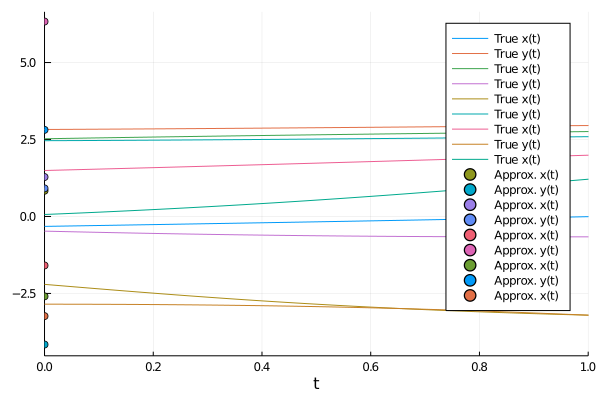

In [262]:
#ps = [p_[[1,2]]; p̂]
tspan = (0.0f0, 1.0f0)
approximate_prob = ODEProblem(dudt, u0, tspan, p̂)
approximate_solution = solve(approximate_prob, Tsit5(), saveat = 0.1)

# Plot
plot(solution_test, label = ["True x(t)" "True y(t)"])
scatter!(approximate_solution, label = ["Approx. x(t)" "Approx. y(t)"])

In [8]:
x = [i*i/5 for i in 1:10]

anim = @animate for i ∈ 1:10
    plot(i.*x)
end

#gif(anim, "anim_fps15.gif", fps = 15)

Animation("C:\\Users\\valpe\\AppData\\Local\\Temp\\jl_R0I0tA", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"])

In [4]:
using Plots